## Standard Imports

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import math
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import StandardScaler

import yfinance as yf
from sklearn.metrics import precision_score, recall_score, f1_score
#from google.colab import drive
import warnings
warnings.filterwarnings("ignore")

## Retrieve Data

### Yahoo Finance

In [2]:
#Yahoo Finance only US indices
start_date = "1998-01-01"
end_date = "2022-12-31"
ticker_list = ['^VIX', '^SPX', '^TYX']
ETF_data = []
for ticker in ticker_list:
    ETF_data.append(yf.download(ticker, start=start_date, end=end_date)['Adj Close'])
df_data = pd.DataFrame(ETF_data).T
df_data.columns = ticker_list
df_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,^VIX,^SPX,^TYX
Date,,,
1998-01-02,23.420000,975.039978,5.848
1998-01-05,24.360001,977.070007,5.729
1998-01-06,25.660000,966.580017,5.718
1998-01-07,25.070000,964.000000,5.793
1998-01-08,26.010000,956.049988,5.746


In [3]:
df_data.describe()

,^VIX,^SPX,^TYX
count,6291.000000,6291.000000,6280.000000
mean,20.572779,1820.321653,3.972019
std,8.575268,944.394588,1.263884
min,9.140000,676.530029,0.937000
25%,14.265000,1166.419983,2.955000
50%,18.940001,1395.410034,4.174000
75%,24.370001,2169.109985,4.966250
max,82.690002,4796.560059,6.742000


In [4]:
df_data.isnull().any(axis=0)

^VIX    False
^SPX    False
^TYX     True
dtype: bool

In [5]:
df_data[df_data.isnull().any(axis=1)]

,^VIX,^SPX,^TYX
Date,,,
1998-10-12,40.070000,997.710022,NaN
1998-11-11,28.469999,1120.969971,NaN
1999-10-11,20.629999,1335.209961,NaN
1999-11-11,22.070000,1381.459961,NaN
2003-11-11,17.540001,1046.569946,NaN
2005-10-10,15.550000,1187.329956,NaN
2005-11-11,11.630000,1234.719971,NaN
2006-10-09,11.680000,1350.660034,NaN
2010-10-11,18.959999,1165.319946,NaN


### Bloomberg

In [3]:
# Load the Excel file
#drive.mount('/content/drive')
#xls = pd.ExcelFile('/content/drive/My Drive/BOA_Capstone/bloomberg_daily.xlsx')
xls = pd.ExcelFile('./bloomberg_daily.xlsx')

# Load all sheets into a dictionary of DataFrames
dfs = {sheet_name: xls.parse(sheet_name, parse_dates=[0]) for sheet_name in xls.sheet_names}

# Rename the date column in each dataframe to 'date' for consistency
for df_name in dfs:
    dfs[df_name] = dfs[df_name].rename(columns={dfs[df_name].columns[0]: 'date'})

# Perform an outer join on 'date' column
df_final = dfs[xls.sheet_names[0]]
for df_name in xls.sheet_names[1:]:
    df_final = pd.merge(df_final, dfs[df_name], on='date', how='outer')

In [4]:
df_final.sort_values(by='date',inplace=True)
df_final.reset_index(drop=True,inplace=True)
df_final.head()

,date,CL1_Comdty,T_rate_1,T_rate_5,T_rate_10,USYC3M10,USYC2M10,US0003M,JPYUSD,GBPUSD,EURUSD,SPGSGC
0,1998-01-02,17.43,5.46,5.63,5.67,41.75,19.5,5.80859,0.007557,1.6450,1.0866,168.4909
1,1998-01-05,16.89,5.35,5.46,5.52,30.35,12.2,5.78125,0.007495,1.6298,1.0776,164.5901
2,1998-01-06,16.91,5.30,5.41,5.49,26.50,5.8,5.71875,0.007453,1.6202,1.0754,164.3572
3,1998-01-07,16.82,5.31,5.45,5.55,43.20,23.8,5.69141,0.007573,1.6246,1.0733,165.7545
4,1998-01-08,16.97,5.20,5.34,5.49,45.90,30.8,5.68750,0.007544,1.6129,1.0784,164.2525


In [5]:
df_data['date'] = df_data.index

In [6]:
df_all = pd.merge(df_final,df_data,on='date',how='outer')
df_all.head()

,date,CL1_Comdty,T_rate_1,T_rate_5,T_rate_10,USYC3M10,USYC2M10,US0003M,JPYUSD,GBPUSD,EURUSD,SPGSGC,^VIX,^SPX,^TYX
0,1998-01-02,17.43,5.46,5.63,5.67,41.75,19.5,5.80859,0.007557,1.6450,1.0866,168.4909,23.420000,975.039978,5.848
1,1998-01-05,16.89,5.35,5.46,5.52,30.35,12.2,5.78125,0.007495,1.6298,1.0776,164.5901,24.360001,977.070007,5.729
2,1998-01-06,16.91,5.30,5.41,5.49,26.50,5.8,5.71875,0.007453,1.6202,1.0754,164.3572,25.660000,966.580017,5.718
3,1998-01-07,16.82,5.31,5.45,5.55,43.20,23.8,5.69141,0.007573,1.6246,1.0733,165.7545,25.070000,964.000000,5.793
4,1998-01-08,16.97,5.20,5.34,5.49,45.90,30.8,5.68750,0.007544,1.6129,1.0784,164.2525,26.010000,956.049988,5.746


In [7]:
df_all = df_all.set_index('date')
df_all

,CL1_Comdty,T_rate_1,T_rate_5,T_rate_10,USYC3M10,USYC2M10,US0003M,JPYUSD,GBPUSD,EURUSD,SPGSGC,^VIX,^SPX,^TYX
date,,,,,,,,,,,,,,
1998-01-02,17.43,5.46,5.63,5.67,41.750,19.500,5.80859,0.007557,1.6450,1.0866,168.4909,23.420000,975.039978,5.848
1998-01-05,16.89,5.35,5.46,5.52,30.350,12.200,5.78125,0.007495,1.6298,1.0776,164.5901,24.360001,977.070007,5.729
1998-01-06,16.91,5.30,5.41,5.49,26.500,5.800,5.71875,0.007453,1.6202,1.0754,164.3572,25.660000,966.580017,5.718
1998-01-07,16.82,5.31,5.45,5.55,43.200,23.800,5.69141,0.007573,1.6246,1.0733,165.7545,25.070000,964.000000,5.793
1998-01-08,16.97,5.20,5.34,5.49,45.900,30.800,5.68750,0.007544,1.6129,1.0784,164.2525,26.010000,956.049988,5.746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,NaN,NaN,NaN,NaN,-58.279,-57.818,NaN,0.007526,1.2062,1.0637,NaN,NaN,NaN,NaN
2022-12-27,79.53,4.75,3.94,3.84,-48.057,-53.945,NaN,0.007491,1.2025,1.0640,1061.4230,21.650000,3829.250000,3.944
2022-12-28,78.96,4.71,3.97,3.88,-56.639,-47.469,4.72986,0.007436,1.2018,1.0612,1057.1730,22.139999,3783.219971,3.974


### HMM_ML

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#!pip install hmmlearn
from hmmlearn import hmm

### Price Return MA

In [9]:
# Price Return MA dataframe
df_all = df_all.rename(columns = {'CL1_Comdty':'Crude_Oil', 'SPGSGC':'Gold', '^SPX':'SP500', '^RUA':'Russell3000', '^TYX':"T30"})
#df_price = df_all[['Crude_Oil', 'Gold', 'SP500', 'T30']]
df_price = df_all.drop(columns = ['^VIX'])

# return_annual, rolling window = 252 days
for col in df_price.columns:
  df_price[col] = df_price[col].pct_change().rolling(252).median() # use median to make it more robust -> better than mean
df_price.dropna(inplace = True)

# add plot-target
df_price['plot'] = df_all['SP500']
df_price.dropna(inplace=True)

df_price.tail()

,Crude_Oil,T_rate_1,T_rate_5,T_rate_10,USYC3M10,USYC2M10,US0003M,JPYUSD,GBPUSD,EURUSD,Gold,SP500,T30,plot
date,,,,,,,,,,,,,,
2022-12-23,0.002004,0.003053,0.003217,0.003300,-0.002336,0.0,0.007825,-0.001024,-0.000316,-0.000223,0.0,-0.001267,0.001714,3844.820068
2022-12-27,0.001266,0.003053,0.003120,0.003009,-0.002593,0.0,0.007615,-0.001031,-0.000316,-0.000143,0.0,-0.001267,0.001559,3829.250000
2022-12-28,0.001266,0.002948,0.003120,0.003009,-0.002404,0.0,0.007526,-0.001038,-0.000316,-0.000143,0.0,-0.001267,0.001714,3783.219971
2022-12-29,0.000624,0.002948,0.003120,0.003009,-0.002088,0.0,0.007376,-0.001038,-0.000316,-0.000143,0.0,-0.001267,0.001714,3849.280029
2022-12-30,0.000624,0.002948,0.003217,0.003300,-0.002404,0.0,0.007376,-0.001038,-0.000316,-0.000143,0.0,-0.001299,0.001975,3839.500000


Model is not converging.  Current: 459680.2850349734 is not greater than 560937.6785763924. Delta is -101257.39354141895


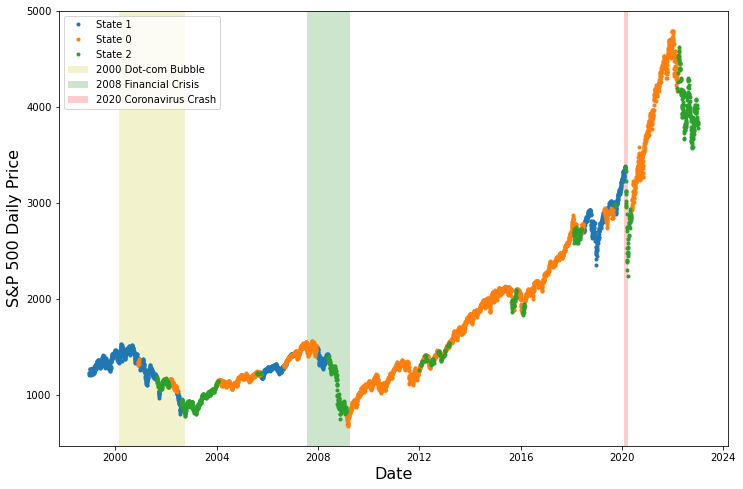

In [10]:
X = df_price.drop(columns = ['plot']).to_numpy()

# HMM model with Price Return df
model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=2)
#model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
model = model.fit(X)
predict = model.predict(X)
states = pd.unique(predict)

# reset index
df_price.reset_index(inplace = True)

# plot
plt.figure(figsize = (12, 8))
for state in states:
    want = (predict == state)
    x = df_price['date'].iloc[want]
    y = df_price['plot'].iloc[want]
    plt.plot(x, y, '.', label=f'State {state}')

plt.axvspan(xmin='2000-03', xmax='2002-10', facecolor="y", alpha=0.2, label='2000 Dot-com Bubble')
plt.axvspan(xmin='2007-08', xmax='2009-04', facecolor="g", alpha=0.2, label='2008 Financial Crisis')
plt.axvspan(xmin='2020-02', xmax='2020-04', facecolor="r", alpha=0.2, label='2020 Coronavirus Crash')

#plt.savefig('/content/drive/My Drive/BOA_Capstone/1', format='png')

plt.legend()
plt.xlabel('Date', fontsize=16)
plt.ylabel('S&P 500 Daily Price', fontsize=16)
plt.show()

In [16]:
split_index = df_price[df_price['date'] == '20181231'].index[0]
split_index

5037

In [17]:
y = predict.reshape(-1,1)
#split train test from X
X_train = X[0:split_index+1, :]
X_test = X[split_index+1:, :]
y_train = y[:split_index+1]
y_test = y[split_index+1:]

In [18]:
y_train_prev = y_train
y_test_prev = y_test

### XGBoost

In [122]:
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

In [123]:
# 创建XGBoost分类器
xgb_classifier = XGBClassifier()

# 定义参数网格
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.1, 0.01, 0.05,0.02,0.03,0.04],
    'n_estimators': [20, 50, 100, 150]
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=5)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和对应的得分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# 在测试集上评估最佳模型
best_model1 = grid_search.best_estimator_
test_accuracy = best_model1.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

# 使用模型进行预测
y_pred = best_model1.predict(X_test).reshape(-1,1)
y_pred_classes = np.argmax(y_pred, axis=1)



Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Score: 0.867209099793509
Test Accuracy: 0.7093253968253969


In [242]:
state_pred = best_model1.predict(X_test)

In [243]:
np.any(state_pred == 2)

True

### Adaboost

In [69]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [70]:
# 创建基础分类器（决策树）
base_classifier = DecisionTreeClassifier()

# 创建Adaboost分类器
adaboost = AdaBoostClassifier(base_classifier)

# 定义参数网格
param_grid = {
    'n_estimators': [50,80, 100,120, 150,200],
    'learning_rate': [0.2,0.1, 0.01, 0.05,0.001,0.02,0.03]
}

# 创建GridSearchCV对象
grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=5)

# 执行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数和对应的得分
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# 在测试集上评估最佳模型
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy using Best Model:", test_accuracy)

# 使用模型进行预测
y_pred = best_model.predict(X_test).reshape(-1,1)
y_pred_classes = np.argmax(y_pred, axis=1)

# 计算精确率、召回率和F1分数
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

Best Parameters: {'learning_rate': 0.01, 'n_estimators': 150}
Best Score: 0.7985139736132785
Test Accuracy using Best Model: 0.7738095238095238
Precision: 0.27959754503653317, Recall: 0.5287698412698413, F1 Score: 0.36578108422689865


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense,Dropout,LSTM,SimpleRNN,Flatten,BatchNormalization,Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split


2023-08-12 20:43:28.137993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
def create_rolled_data(X,y,rolling_num=15):
    X_roll = []
    y_roll = []
    for i in range(rolling_num, X.shape[0]):
        X_roll.append(X[i-rolling_num:i,:])
        y_roll.append(y[i,0])
    X_roll, y_roll = np.array(X_roll), np.array(y_roll)

    print(X_roll.shape)
    print(y_roll.shape)

    # Reshaping
    X_roll = np.reshape(X_roll, (X_roll.shape[0], X_roll.shape[1], X_roll.shape[2]))
    y_roll = np.reshape(y_roll,(y_roll.shape[0],1))
    
    return X_roll,y_roll

In [19]:
roll_num = 30
X_roll,y_roll = create_rolled_data(X,y,rolling_num=roll_num)

(6016, 30, 13)
(6016,)


In [20]:
X_train = X_roll[0:split_index+1-roll_num, :]
X_test = X_roll[split_index+1-roll_num:, :]
y_train = y_roll[:split_index+1-roll_num]
y_test = y_roll[split_index+1-roll_num:]

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

print(y_train.shape)
print(y_test.shape)

(5008,)
(1008,)


### Portfolio Optimization - regime classified by PRICE RETURN

In [21]:
# retrieve portfolio assets from Yahoo Finance
start_date = "2019-01-01"
end_date = "2022-12-31"
ticker_list = ['MSCI', 'EEM', 'GOVT', 'LQD', 'HYG', 'GLD', 'WTI', 'DJCI']
assets = []

for ticker in ticker_list:
    assets.append(yf.download(ticker, start=start_date, end=end_date)['Adj Close'])

df_p = pd.DataFrame(assets).T
df_p.columns = ticker_list

# turn the daily_price into daily_return
df_p = df_p.pct_change().dropna()

df_p.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,MSCI,EEM,GOVT,LQD,HYG,GLD,WTI,DJCI
Date,,,,,,,,
2019-01-03,-0.038111,-0.018131,0.005634,0.000442,0.000494,0.009066,-0.013453,0.007540
2019-01-04,0.037215,0.032250,-0.005202,-0.000618,0.016784,-0.008086,0.120454,0.011225
2019-01-07,0.004638,0.002268,-0.002011,0.000089,0.009709,0.003458,0.050710,0.003756
2019-01-08,0.020777,0.003771,-0.002015,0.002209,0.006491,-0.002708,0.011583,0.005637
2019-01-09,0.009778,0.017781,0.000000,0.003791,0.001195,0.006418,0.041985,0.013026


In [246]:
merged_states = np.hstack((y_train_prev.reshape(1,-1), state_pred.reshape(1,-1)))
merged_states = merged_states.reshape(-1)
merged_states.shape

(6046,)

In [251]:
# incorporate 'state' column into the dataframe
df_price['state'] = np.nan
non_nan_rows = df_price.dropna().index
mask_non_nan = ~df_price['plot'].isna()
df_price.loc[mask_non_nan, 'state'] = merged_states

df_price = df_price.set_index('date')
df_price.head()

,Crude_Oil,T_rate_1,T_rate_5,T_rate_10,USYC3M10,USYC2M10,US0003M,JPYUSD,GBPUSD,EURUSD,Gold,SP500,T30,plot,state
date,,,,,,,,,,,,,,,
1998-12-22,-0.000670,0.0,0.0,0.0,-0.010832,-0.082217,0.0,-0.000764,-0.000362,0.0,-0.000691,0.001145,0.0,1203.569946,1
1998-12-23,-0.000309,0.0,0.0,0.0,-0.007602,-0.073074,0.0,-0.000724,-0.000362,0.0,-0.000691,0.001145,0.0,1228.540039,1
1998-12-24,-0.000670,0.0,0.0,0.0,-0.003521,-0.066041,0.0,-0.000724,-0.000362,0.0,-0.000691,0.001145,0.0,1226.270020,1
1998-12-28,-0.000309,0.0,0.0,0.0,-0.007602,-0.073074,0.0,-0.000724,-0.000362,0.0,-0.000682,0.001145,0.0,1225.489990,1
1998-12-29,0.000000,0.0,0.0,0.0,-0.007602,-0.066041,0.0,-0.000724,-0.000362,0.0,-0.000682,0.001217,0.0,1241.810059,1


In [252]:
# merge portfolio dataframe and regime states, drop null values
df = df_p.merge(df_price['state'], left_index=True, right_index=True, how='left').dropna()

pd.concat([df.head(), df.tail()])

,MSCI,EEM,GOVT,LQD,HYG,GLD,WTI,DJCI,state
Date,,,,,,,,,
2019-01-03,-0.038111,-0.018131,0.005634,0.000442,0.000494,0.009066,-0.013453,0.007540,1
2019-01-04,0.037215,0.032250,-0.005202,-0.000618,0.016784,-0.008086,0.120454,0.011225,1
2019-01-07,0.004639,0.002268,-0.002011,0.000088,0.009710,0.003458,0.050710,0.003756,1
2019-01-08,0.020777,0.003770,-0.002015,0.002209,0.006491,-0.002708,0.011583,0.005637,1
2019-01-09,0.009778,0.017781,0.000000,0.003792,0.001194,0.006418,0.041985,0.013026,1
2022-12-23,0.003244,-0.001321,-0.004350,-0.003073,0.002561,0.002998,0.039927,0.000000,1
2022-12-27,-0.007309,0.014815,-0.005679,-0.012890,-0.010351,0.008430,0.010471,0.000000,1
2022-12-28,-0.013010,-0.014599,-0.001318,-0.003123,-0.013448,-0.004506,-0.056995,0.000000,1
2022-12-29,0.038465,0.016667,0.003080,0.007119,0.012943,0.005598,0.023810,0.000000,2


In [253]:
state_pred

array([1, 1, 1, ..., 1, 2, 1])

           MSCI       EEM      GOVT       LQD       HYG       GLD       WTI  \
state                                                                         
0      0.001456  0.000695 -0.000099  0.000070  0.000317  0.000673  0.002743   
1      0.001758 -0.000377 -0.000156 -0.000099  0.000066 -0.000368  0.001010   
2      0.001022 -0.000677  0.000480  0.000337 -0.000423  0.000613 -0.001335   

           DJCI  
state            
0      0.000448  
1     -0.000031  
2     -0.001384  


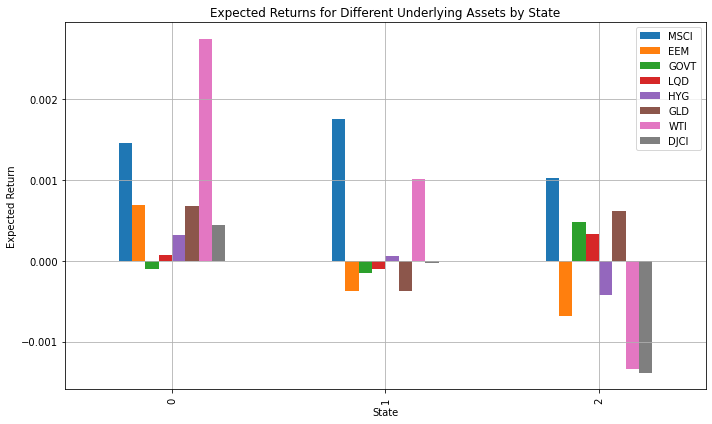

In [254]:
# Filter for states 0 and 1 (if necessary)
filtered_data = df[df['state'].isin([0, 1, 2])]

# Group by 'state' and compute the mean for each group
expected_returns = filtered_data.groupby('state').mean()

print(expected_returns)

# Plot
ticker_list = ['MSCI', 'EEM', 'GOVT', 'LQD', 'HYG', 'GLD', 'WTI', 'DJCI']

expected_returns_demo = pd.DataFrame({ticker: expected_returns[ticker] for ticker in ticker_list}, index=[0, 1, 2])

expected_returns_demo.plot(kind='bar', figsize=(10, 6))
plt.title('Expected Returns for Different Underlying Assets by State')
plt.xlabel('State')
plt.ylabel('Expected Return')
plt.grid()
plt.tight_layout()

plt.savefig('XGBoost_exp_return.png')
plt.show()

In [256]:
import cvxpy as cp

def optimize_portfolio(returns, risk_aversion):

    # Number of assets
    n = returns.shape[1]

    # Calculate expected returns and covariance matrix
    r = returns.mean().values
    Sigma = returns.cov().values

    # Portfolio weights
    w = cp.Variable(n)

    # Objective function
    objective = cp.Minimize(cp.quad_form(w, Sigma) - risk_aversion * r.T @ w)

    # Constraints
    constraints = [cp.sum(w) == 1, w >= 0]

    # Define and solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value

risk_aversion = 1.0
optimal_weights_by_state = {}

# Optimize portfolio based on state data
for state in [0, 1, 2]:
    state_returns = df[df['state'] == state].drop(columns=['state'])
    optimal_weights_by_state[state] = optimize_portfolio(state_returns, risk_aversion)

for state, weights in optimal_weights_by_state.items():
    print(f"Optimal weights for State {state}:", weights)

# Optimize portfolio based on all states data
all_state_returns = df.drop(columns=['state'])
optimal_weights_all_states = optimize_portfolio(all_state_returns, risk_aversion)

print("\nOptimal weights for all states:", optimal_weights_all_states)

Optimal weights for State 0: [ 6.10961768e-01 -1.23007688e-22 -1.22185210e-22 -1.09842335e-23
 -6.75729946e-23 -3.92887765e-23  3.89038232e-01 -6.85527227e-23]
Optimal weights for State 1: [ 1.00000000e+00  2.23360978e-25  7.27069360e-25  5.44961721e-25
 -1.10545241e-22  4.28312874e-25 -5.15732556e-23  7.14946354e-25]
Optimal weights for State 2: [ 1.89431850e-01  3.71935770e-23  4.98325715e-01  4.39490276e-23
  1.00894678e-22  3.12242436e-01  4.59319199e-23 -2.23421322e-22]

Optimal weights for all states: [ 8.75147797e-01 -1.01957831e-22 -1.10047284e-22 -1.10379865e-22
 -1.06120357e-22 -1.02541790e-22  1.24852203e-01 -4.90027895e-23]


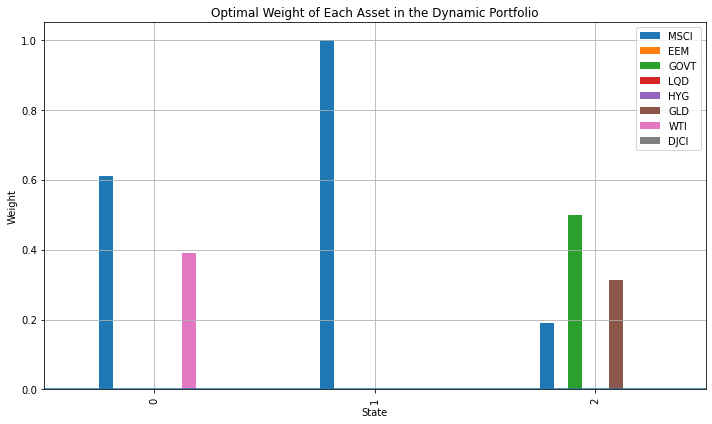

In [257]:
# Plot optimal weights under different state
index = [0, 1, 2]
weights = pd.DataFrame(columns = ticker_list, index = index)
weights
optimal_weights = pd.DataFrame(optimal_weights_by_state).T

for i in range(len(index)):
  for j in range(len(ticker_list)):
    weights.iloc[i,j]= optimal_weights.iloc[i,j]

weights.plot(kind='bar', figsize=(10,6))
plt.title('Optimal Weight of Each Asset in the Dynamic Portfolio')
plt.xlabel('State')
plt.ylabel('Weight')
plt.axhline(0)
plt.grid()
plt.tight_layout()
plt.savefig('XGBoost_optimal_w.png')
plt.show()

[*********************100%***********************]  1 of 1 completed


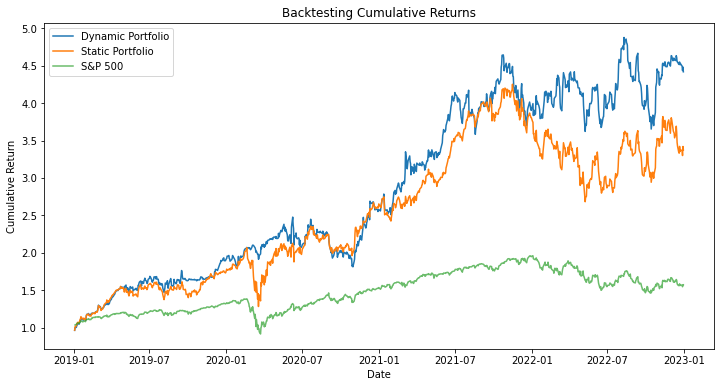

In [258]:
# Calculate portfolio's daily returns for each state
df['daily_return_dynamic'] = 0
for state, weights in optimal_weights_by_state.items():
    mask = df['state'] == state
    df.loc[mask, 'daily_return_dynamic'] = df[mask][ticker_list].dot(weights)

# Compute the cumulative returns for the dynamic portfolio
df['cum_return_dynamic'] = (1 + df['daily_return_dynamic']).cumprod()

# Compute the cumulative returns for the static portfolio
df['daily_return_static'] = df[ticker_list].dot(optimal_weights_all_states)
df['cum_return_static'] = (1 + df['daily_return_static']).cumprod()

# Compute the cumulative returns for the S&P 500
sp500 = yf.download('^GSPC', start=df.index.min(), end=df.index.max())['Close']
df = pd.merge(df, sp500, left_index=True, right_index=True, how='left')
df.rename(columns={'Close': 'SP500'}, inplace=True)
df['daily_return_SP500'] = df['SP500'].pct_change()
df['cum_return_SP500'] = (1 + df['daily_return_SP500']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cum_return_dynamic'], label='Dynamic Portfolio')
plt.plot(df.index, df['cum_return_static'], label='Static Portfolio')
plt.plot(df.index, df['cum_return_SP500'], label='S&P 500', alpha=0.7)
plt.legend()
plt.title('Backtesting Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.savefig('cum_return_xgboost.png')
plt.show()

### Volatility MA

In [29]:
# volatility MA dataframe
df_vol = df_all[['Crude_Oil', 'Gold', 'SP500', 'T30']]

# vol_annual, rolling window = 252 days
from math import sqrt
for col in df_vol.columns:
  df_vol[col] = df_vol[col].pct_change().rolling(252).std()*sqrt(252)
df_vol.dropna(inplace = True)

# add VIX
df_vol = pd.merge(df_vol, df_all['^VIX'], left_index = True, right_index = True)

# add plot-target
df_vol['plot'] = df_all['SP500'].pct_change()
df_vol.dropna(inplace=True)

df_vol.head()

,Crude_Oil,Gold,SP500,T30,^VIX,plot
date,,,,,,
1998-12-22,0.465143,0.129746,0.201261,0.131616,22.780001,0.000607
1998-12-23,0.466826,0.127692,0.202233,0.130896,20.209999,0.020747
1998-12-24,0.466882,0.127696,0.201910,0.130922,21.480000,-0.001848
1998-12-28,0.467260,0.127091,0.201671,0.130363,23.500000,-0.000636
1998-12-29,0.467477,0.126827,0.199666,0.130421,22.180000,0.013317


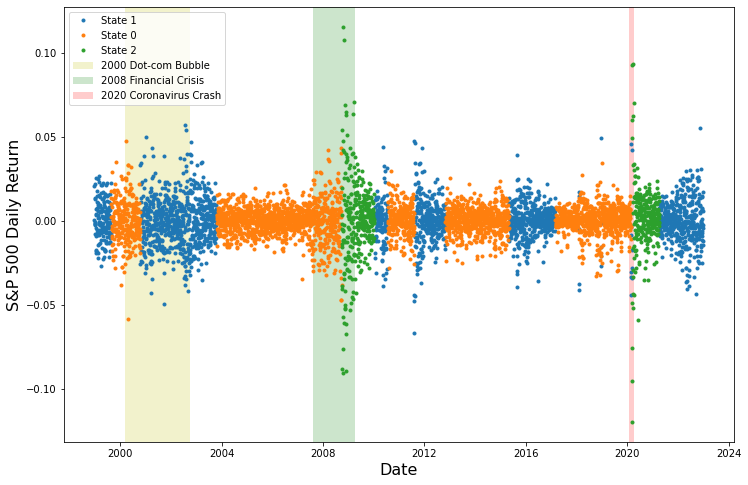

In [30]:
X = df_vol.drop(columns = ['plot']).to_numpy()

# HMM model with Volatility df
model = hmm.GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=1)
#model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
model = model.fit(X)
predict = model.predict(X)
states = pd.unique(predict)

# reset index
df_vol.reset_index(inplace = True)

# plot
plt.figure(figsize = (12, 8))
for state in states:
    want = (predict == state)
    x = df_vol['date'].iloc[want]
    y = df_vol['plot'].iloc[want]
    plt.plot(x, y, '.', label = f'State {state}')

plt.axvspan(xmin='2000-03', xmax='2002-10', facecolor="y", alpha=0.2, label='2000 Dot-com Bubble')
plt.axvspan(xmin='2007-08', xmax='2009-04', facecolor="g", alpha=0.2, label='2008 Financial Crisis')
plt.axvspan(xmin='2020-02', xmax='2020-04', facecolor="r", alpha=0.2, label='2020 Coronavirus Crash')

#plt.savefig('/content/drive/My Drive/BOA_Capstone/8', format='png')

plt.legend()
plt.xlabel('Date', fontsize=16)
plt.ylabel('S&P 500 Daily Return', fontsize=16)
plt.show()

In [31]:
split_index = df_vol[df_vol['date'] == '20181231'].index[0]
split_index

5037

In [32]:
y = predict.reshape(-1,1)
#split train test from X
X_train = X[0:split_index+1, :]
X_test = X[split_index+1:, :]
y_train = y[:split_index+1]
y_test = y[split_index+1:]

In [33]:
roll_num = 30
X_roll,y_roll = create_rolled_data(X,y,rolling_num=roll_num)
y_train_prev = y_train
X_train = X_roll[0:split_index+1-roll_num, :]
X_test = X_roll[split_index+1-roll_num:, :]
y_train = y_roll[:split_index+1-roll_num]
y_test = y_roll[split_index+1-roll_num:]

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

print(y_train.shape)
print(y_test.shape)

(6016, 30, 5)
(6016,)
(5008,)
(1008,)


In [27]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn=None, units=5,optimizer='adam', dropout_rate=0.2, activation='sigmoid', epochs=1, batch_size=32, verbose=1):
        self.build_fn = build_fn
        self.units = units
        self.optimizer = optimizer
        self.dropout_rate = dropout_rate
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model_ = self.build_fn(optimizer=self.optimizer, dropout_rate=self.dropout_rate, activation=self.activation)

    def fit(self, X, y):
        self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        predictions = self.model_.predict(X)
        return np.argmax(predictions, axis=1)

    def score(self, X, y):
        loss, accuracy = self.model_.evaluate(X, y, verbose=self.verbose)
        return accuracy

In [34]:

from sklearn.model_selection import RandomizedSearchCV
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# 定义模型
def create_model(units = 15, optimizer='adam', dropout_rate=0.2, activation='sigmoid'):
    model = Sequential([
        GRU(units=units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=True),
        Dropout(dropout_rate),
        BatchNormalization(),
        Flatten(),
        #Dense(10,activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifierWrapper(build_fn=create_model, verbose=0)

# 定义参数分布
param_distributions = {
    'units':[5,10,15,20,25,30],
    'optimizer': ['adam','rmsprop'],
    'dropout_rate': [0.1, 0.2, 0.3,0.4,0.5],
    'activation': ['sigmoid', 'relu'],
    'batch_size': [16, 32, 64,80,128],
    'epochs': [10, 15, 20]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=10, cv=3, verbose=1, n_jobs=-1)
random_search_result = random_search.fit(X_train, y_train)

# 输出最佳参数
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))


# 使用最佳参数重新训练模型
best_model2 = random_search_result.best_estimator_.model_
loss, accuracy = best_model2.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best: 0.896569 using {'units': 30, 'optimizer': 'rmsprop', 'epochs': 15, 'dropout_rate': 0.3, 'batch_size': 32, 'activation': 'sigmoid'}
32/32 [==============================] - 0s 4ms/step - loss: 0.3631 - accuracy: 0.8462
Test Loss: 0.3631165623664856, Test Accuracy: 0.846230149269104


In [35]:
state_pred = np.argmax(best_model2.predict(X_test),axis=1)
merged_states = np.hstack((y_train_prev.reshape(1,-1), state_pred.reshape(1,-1)))
merged_states = merged_states.reshape(-1)
merged_states.shape

32/32 [==============================] - 0s 3ms/step


(6046,)

### Portfolio Optimization - regime classified by VOLATILITY

In [38]:
# incorporate 'state' column into the dataframe
df_vol['state'] = np.nan
non_nan_rows = df_price.dropna().index
mask_non_nan = ~df_vol['plot'].isna()
df_vol.loc[mask_non_nan, 'state'] = merged_states

df_vol = df_vol.set_index('date')
df_vol.head()

,Crude_Oil,Gold,SP500,T30,^VIX,plot,state
date,,,,,,,
1998-12-22,0.465143,0.129746,0.201261,0.131616,22.780001,0.000607,1
1998-12-23,0.466826,0.127692,0.202233,0.130896,20.209999,0.020747,1
1998-12-24,0.466882,0.127696,0.201910,0.130922,21.480000,-0.001848,1
1998-12-28,0.467260,0.127091,0.201671,0.130363,23.500000,-0.000636,1
1998-12-29,0.467477,0.126827,0.199666,0.130421,22.180000,0.013317,1


In [39]:
# merge portfolio dataframe and regime states, drop null values
df = df_p.merge(df_vol['state'], left_index=True, right_index=True, how='left').dropna()

pd.concat([df.head(), df.tail()])

,MSCI,EEM,GOVT,LQD,HYG,GLD,WTI,DJCI,state
Date,,,,,,,,,
2019-01-03,-0.038111,-0.018131,0.005634,0.000442,0.000494,0.009066,-0.013453,0.007540,0
2019-01-04,0.037215,0.032250,-0.005202,-0.000618,0.016784,-0.008086,0.120454,0.011225,0
2019-01-07,0.004638,0.002268,-0.002011,0.000089,0.009709,0.003458,0.050710,0.003756,0
2019-01-08,0.020777,0.003771,-0.002015,0.002209,0.006491,-0.002708,0.011583,0.005637,0
2019-01-09,0.009778,0.017781,0.000000,0.003791,0.001195,0.006418,0.041985,0.013026,0
2022-12-23,0.003244,-0.001321,-0.004350,-0.003073,0.002561,0.002998,0.039927,0.000000,1
2022-12-27,-0.007309,0.014815,-0.005679,-0.012890,-0.010351,0.008430,0.010471,0.000000,1
2022-12-28,-0.013010,-0.014599,-0.001318,-0.003123,-0.013448,-0.004506,-0.056995,0.000000,1
2022-12-29,0.038465,0.016667,0.003080,0.007119,0.012942,0.005598,0.023810,0.000000,1


           MSCI       EEM      GOVT       LQD       HYG       GLD       WTI  \
state                                                                         
0      0.001463 -0.000223  0.000296  0.000433  0.000246  0.000590 -0.001921   
1      0.000590 -0.000845 -0.000251 -0.000791 -0.000538 -0.000105  0.002267   
2      0.002691  0.002000 -0.000014  0.000892  0.000916  0.000835  0.004292   

           DJCI  
state            
0     -0.000374  
1     -0.000252  
2      0.000760  


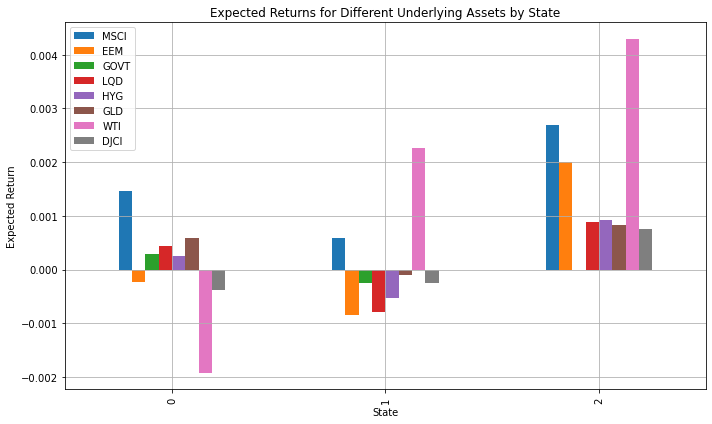

In [40]:
# Filter for states 0 and 1 (if necessary)
filtered_data = df[df['state'].isin([0, 1, 2])]

# Group by 'state' and compute the mean for each group
expected_returns = filtered_data.groupby('state').mean()

print(expected_returns)

# Plot
ticker_list = ['MSCI', 'EEM', 'GOVT', 'LQD', 'HYG', 'GLD', 'WTI', 'DJCI']

expected_returns_demo = pd.DataFrame({ticker: expected_returns[ticker] for ticker in ticker_list}, index=[0, 1, 2])

expected_returns_demo.plot(kind='bar', figsize=(10, 6))
plt.title('Expected Returns for Different Underlying Assets by State')
plt.xlabel('State')
plt.ylabel('Expected Return')
plt.grid()
plt.tight_layout()
#plt.savefig('/content/drive/My Drive/BOA_Capstone/9', format='png')
plt.show()

In [42]:
import cvxpy as cp

def optimize_portfolio(returns, risk_aversion):

    # Number of assets
    n = returns.shape[1]

    # Calculate expected returns and covariance matrix
    r = returns.mean().values
    Sigma = returns.cov().values

    # Portfolio weights
    w = cp.Variable(n)

    # Objective function
    objective = cp.Minimize(cp.quad_form(w, Sigma) - risk_aversion * r.T @ w)

    # Constraints
    constraints = [cp.sum(w) == 1, w >= 0]

    # Define and solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve()

    return w.value

risk_aversion = 1.0
optimal_weights_by_state = {}

# Optimize portfolio based on state data
for state in [0, 1, 2]:
    state_returns = df[df['state'] == state].drop(columns=['state'])
    optimal_weights_by_state[state] = optimize_portfolio(state_returns, risk_aversion)

for state, weights in optimal_weights_by_state.items():
    print(f"Optimal weights for State {state}:", weights)

# Optimize portfolio based on all states data
all_state_returns = df.drop(columns=['state'])
optimal_weights_all_states = optimize_portfolio(all_state_returns, risk_aversion)

print("\nOptimal weights for all states:", optimal_weights_all_states)

Optimal weights for State 0: [ 1.00000000e+00  2.22029804e-22  5.59726375e-23  5.58764885e-23
  5.58274048e-23  5.56066221e-23 -1.48240399e-22  1.11094483e-22]
Optimal weights for State 1: [ 4.40695054e-01 -3.20082807e-22 -1.00785170e-22 -1.42040793e-22
 -2.37508528e-22  2.40016926e-01  3.19288020e-01 -1.68870379e-22]
Optimal weights for State 2: [ 6.16878440e-01 -8.70095287e-23  9.35754061e-25 -5.42756618e-23
 -1.08661539e-22 -5.52452531e-23  3.83121560e-01  2.17537048e-24]

Optimal weights for all states: [ 8.75147580e-01 -1.16592162e-22 -1.19839954e-22 -1.75105375e-22
 -1.18160577e-22 -1.20257348e-22  1.24852420e-01 -1.18913829e-22]


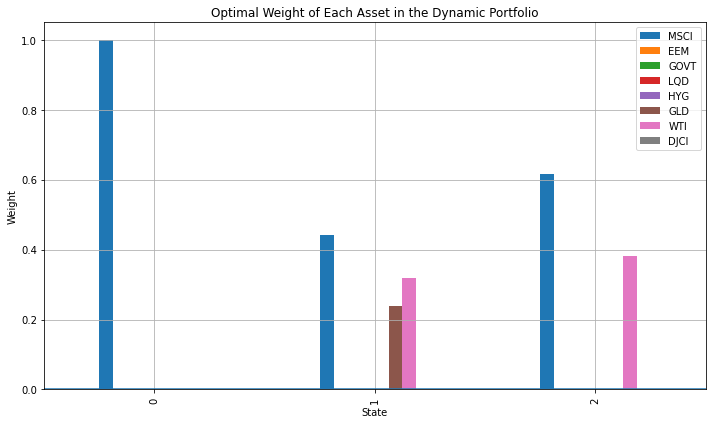

In [43]:
# Plot optimal weights under different state
index = [0, 1, 2]
weights = pd.DataFrame(columns = ticker_list, index = index)
weights
optimal_weights = pd.DataFrame(optimal_weights_by_state).T

for i in range(len(index)):
  for j in range(len(ticker_list)):
    weights.iloc[i,j]= optimal_weights.iloc[i,j]

weights.plot(kind='bar', figsize=(10,6))
plt.title('Optimal Weight of Each Asset in the Dynamic Portfolio')
plt.xlabel('State')
plt.ylabel('Weight')
plt.axhline(0)
plt.grid()
plt.tight_layout()
plt.savefig('LSTM_optimal_w', format='png')
plt.show()

[*********************100%***********************]  1 of 1 completed


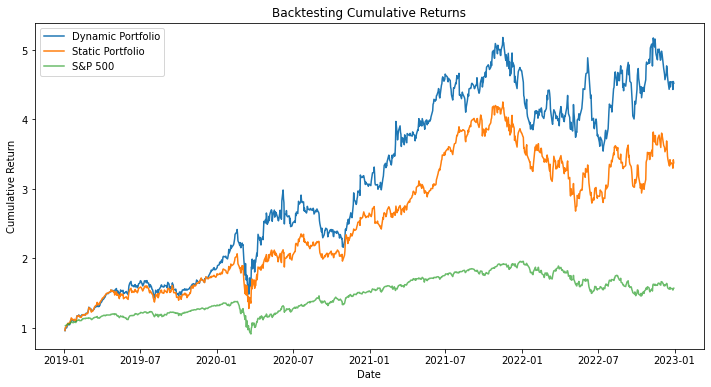

In [44]:
# Calculate portfolio's daily returns for each state
df['daily_return_dynamic'] = 0
for state, weights in optimal_weights_by_state.items():
    mask = df['state'] == state
    df.loc[mask, 'daily_return_dynamic'] = df[mask][ticker_list].dot(weights)

# Compute the cumulative returns for the dynamic portfolio
df['cum_return_dynamic'] = (1 + df['daily_return_dynamic']).cumprod()

# Compute the cumulative returns for the static portfolio
df['daily_return_static'] = df[ticker_list].dot(optimal_weights_all_states)
df['cum_return_static'] = (1 + df['daily_return_static']).cumprod()

# Compute the cumulative returns for the S&P 500
sp500 = yf.download('^GSPC', start=df.index.min(), end=df.index.max())['Close']
df = pd.merge(df, sp500, left_index=True, right_index=True, how='left')
df.rename(columns={'Close': 'SP500'}, inplace=True)
df['daily_return_SP500'] = df['SP500'].pct_change()
df['cum_return_SP500'] = (1 + df['daily_return_SP500']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cum_return_dynamic'], label='Dynamic Portfolio')
plt.plot(df.index, df['cum_return_static'], label='Static Portfolio')
plt.plot(df.index, df['cum_return_SP500'], label='S&P 500', alpha=0.7)
plt.legend()
plt.title('Backtesting Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
#plt.savefig('/content/drive/My Drive/BOA_Capstone/14', format='png')
plt.show()

### Investment Strategies

In [150]:
df.head()

,MSCI,EEM,GOVT,LQD,HYG,GLD,WTI,DJCI,state,daily_return_dynamic,cum_return_dynamic,daily_return_static,cum_return_static,SP500,daily_return_SP500,cum_return_SP500,SP500
Date,,,,,,,,,,,,,,,,,
2019-01-03,-0.038111,-0.018131,0.005634,0.000442,0.000494,0.009066,-0.013453,0.007540,0,-0.038111,0.961889,-0.035032,0.964968,2447.889893,NaN,NaN,2447.889893
2019-01-04,0.037215,0.032249,-0.005202,-0.000618,0.016784,-0.008086,0.120454,0.011225,0,0.037215,0.997686,0.047608,1.010908,2531.939941,0.034336,1.034336,2531.939941
2019-01-07,0.004638,0.002268,-0.002011,0.000089,0.009710,0.003458,0.050710,0.003756,0,0.004638,1.002314,0.010390,1.021412,2549.689941,0.007010,1.041587,2549.689941
2019-01-08,0.020777,0.003770,-0.002016,0.002209,0.006492,-0.002708,0.011583,0.005637,0,0.020777,1.023139,0.019629,1.041461,2574.409912,0.009695,1.051685,2574.409912
2019-01-09,0.009778,0.017781,0.000000,0.003791,0.001194,0.006418,0.041985,0.013026,0,0.009778,1.033143,0.013799,1.055832,2584.959961,0.004098,1.055995,2584.959961


### Performance Measurements

In [45]:
def calculate_max_drawdown(cumulative_returns):
    """
    Compute the maximum drawdown for a series of cumulative returns.
    """
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cumulative_returns)
    # Calculate the running drawdown
    drawdown = (cumulative_returns - running_max) / running_max
    # Return the maximum drawdown
    return drawdown.min()

In [46]:
# Given the df DataFrame, we can compute the performance metrics

# Define risk-free rate
risk_free_rate = 0.0402

# Calculate annualized returns
annualized_return_dynamic = (df['cum_return_dynamic'].iloc[-1]) ** (252.0/len(df)) - 1
annualized_return_static = (df['cum_return_static'].iloc[-1]) ** (252.0/len(df)) - 1
annualized_return_SP500 = (df['cum_return_SP500'].iloc[-1]) ** (252.0/len(df)) - 1

# Calculate annualized volatility
annualized_vol_dynamic = df['daily_return_dynamic'].std() * (252 ** 0.5)
annualized_vol_static = df['daily_return_static'].std() * (252 ** 0.5)
annualized_vol_SP500 = df['daily_return_SP500'].std() * (252 ** 0.5)

# Calculate Sharpe ratios
sharpe_dynamic = (annualized_return_dynamic - risk_free_rate) / annualized_vol_dynamic
sharpe_static = (annualized_return_static - risk_free_rate) / annualized_vol_static
sharpe_SP500 = (annualized_return_SP500 - risk_free_rate) / annualized_vol_SP500

# Calculate downside volatility
downside_vol_dynamic = df[df['daily_return_dynamic'] < 0]['daily_return_dynamic'].std() * (252 ** 0.5)
downside_vol_static = df[df['daily_return_static'] < 0]['daily_return_static'].std() * (252 ** 0.5)
downside_vol_SP500 = df[df['daily_return_SP500'] < 0]['daily_return_SP500'].std() * (252 ** 0.5)

# Calculate Sortino ratios
sortino_dynamic = (annualized_return_dynamic - risk_free_rate) / downside_vol_dynamic
sortino_static = (annualized_return_static - risk_free_rate) / downside_vol_static
sortino_SP500 = (annualized_return_SP500 - risk_free_rate) / downside_vol_SP500

# Calculate Maximum Drawdown
max_drawdown_dynamic = calculate_max_drawdown(df['cum_return_dynamic'])
max_drawdown_static = calculate_max_drawdown(df['cum_return_static'])
max_drawdown_SP500 = calculate_max_drawdown(df['cum_return_SP500'].dropna())

performance_metrics = {
    "Portfolio": ["Dynamic", "Static", "S&P 500"],
    "Annualized Return": [annualized_return_dynamic, annualized_return_static, annualized_return_SP500],
    "Annualized Volatility": [annualized_vol_dynamic, annualized_vol_static, annualized_vol_SP500],
    "Sharpe Ratio": [sharpe_dynamic, sharpe_static, sharpe_SP500],
    "Sortino Ratio": [sortino_dynamic, sortino_static, sortino_SP500],
    "Max Drawdown" : [max_drawdown_dynamic, max_drawdown_static, max_drawdown_SP500]
}

performance_df = pd.DataFrame(performance_metrics)
performance_df

,Portfolio,Annualized Return,Annualized Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown
0,Dynamic,0.458650,0.384351,1.088718,1.589689,-0.384707
1,Static,0.355964,0.367982,0.858096,1.198041,-0.380452
2,S&P 500,0.119942,0.228927,0.348332,0.419803,-0.339250
